In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
#!unzip "/content/drive/MyDrive/Lavanya K/images.zip"

In [6]:
import cv2
import imghdr

C:\Users\Harsha\AppData\Local\Temp\ipykernel_3012\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
import pandas as pd

data = pd.read_csv("Dataset/Dataset.csv")
data.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,2020136N10088,2020,25,NI,BB,AMPHAN,15-05-2020 06:00,NR,9.50000,87.5000,...,,,,,,,,,5,271
1,2020136N10088,2020,25,NI,BB,AMPHAN,15-05-2020 09:00,NR,9.50504,87.2425,...,,,,,,,,,5,270
2,2020136N10088,2020,25,NI,BB,AMPHAN,15-05-2020 12:00,TS,9.50000,87.0000,...,,,,,,,,,5,267
3,2020136N10088,2020,25,NI,BB,AMPHAN,15-05-2020 15:00,TS,9.48499,86.7850,...,,,,,,,,,4,270
4,2020136N10088,2020,25,NI,BB,AMPHAN,15-05-2020 18:00,TS,9.50000,86.6000,...,,,,,,,,,3,287


In [8]:
features = ["SEASON", "SUBBASIN", "ISO_TIME", "WMO_WIND"]
#features.append("WMO_PRES")
data = data[features]
data.head()

,SEASON,SUBBASIN,ISO_TIME,WMO_WIND
0,2020,BB,15-05-2020 06:00,
1,2020,BB,15-05-2020 09:00,
2,2020,BB,15-05-2020 12:00,
3,2020,BB,15-05-2020 15:00,
4,2020,BB,15-05-2020 18:00,


## Mapping Images to the Winddata

In [9]:
from datetime import datetime

date_series = data["ISO_TIME"]
datetime_series = pd.to_datetime(date_series, format="%d-%m-%Y %H:%M")
formatted_series = datetime_series.dt.strftime("%d%b%Y_%H%M").str.upper()
file_name = "3DIMG_" + formatted_series + "_L1C_ASIA_MER_IR1_V01R00.jpg"

file_name.head()

0    3DIMG_15MAY2020_0600_L1C_ASIA_MER_IR1_V01R00.jpg
1    3DIMG_15MAY2020_0900_L1C_ASIA_MER_IR1_V01R00.jpg
2    3DIMG_15MAY2020_1200_L1C_ASIA_MER_IR1_V01R00.jpg
3    3DIMG_15MAY2020_1500_L1C_ASIA_MER_IR1_V01R00.jpg
4    3DIMG_15MAY2020_1800_L1C_ASIA_MER_IR1_V01R00.jpg
Name: ISO_TIME, dtype: object

In [10]:
data["IR1"] = file_name

In [11]:
data.head()

,SEASON,SUBBASIN,ISO_TIME,WMO_WIND,IR1
0,2020,BB,15-05-2020 06:00,,3DIMG_15MAY2020_0600_L1C_ASIA_MER_IR1_V01R00.jpg
1,2020,BB,15-05-2020 09:00,,3DIMG_15MAY2020_0900_L1C_ASIA_MER_IR1_V01R00.jpg
2,2020,BB,15-05-2020 12:00,,3DIMG_15MAY2020_1200_L1C_ASIA_MER_IR1_V01R00.jpg
3,2020,BB,15-05-2020 15:00,,3DIMG_15MAY2020_1500_L1C_ASIA_MER_IR1_V01R00.jpg
4,2020,BB,15-05-2020 18:00,,3DIMG_15MAY2020_1800_L1C_ASIA_MER_IR1_V01R00.jpg


## Wind column Preprocessing

In [12]:
data['WMO_WIND'] = data['WMO_WIND'].replace(' ', 0)
data['WMO_WIND'] = pd.to_numeric(data['WMO_WIND'], errors='coerce')

## Highlighting the clouds of the Images

In [13]:
def image_highlighting(cropped_image):
    
    img_array = np.array(cropped_image)

    single_channel = img_array[:, :, 0]

    ret1, thresh = cv2.threshold(single_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    opening = clear_border(opening)
    sure_bg = cv2.dilate(opening, kernel, iterations=10)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret2, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret3, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 10
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_array, markers)

    img_array[markers == -1] = [255, 87, 51]
    img2 = color.label2rgb(markers, bg_label=0)
    plt.subplot(1, 2, 2)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title('Highlighted Image')

    plt.tight_layout()
    plt.show()
    
    return img_array

## Saving the Pre-processed images locally

In [14]:
def save_processed_image(img_array, filename):
    output_dir = 'Dataset/processed_images/'
    output_path = os.path.join(output_dir, filename)
    processed_image = Image.fromarray(img_array)
    processed_image.save(output_path)
    print(f"Processed image saved at: {output_path}")

## Cropping the required section of the images

In [15]:
def image_crop(image, filename):
    if int(filename[11:15]) <= 2020 or 'MAY2021' in filename or 'SEP2021' in filename:
        crop_coords = (150, 300, 600, 700)
    else:
        crop_coords = (300, 600, 1200, 1300)
    cropped_image = image.crop(crop_coords)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    return cropped_image

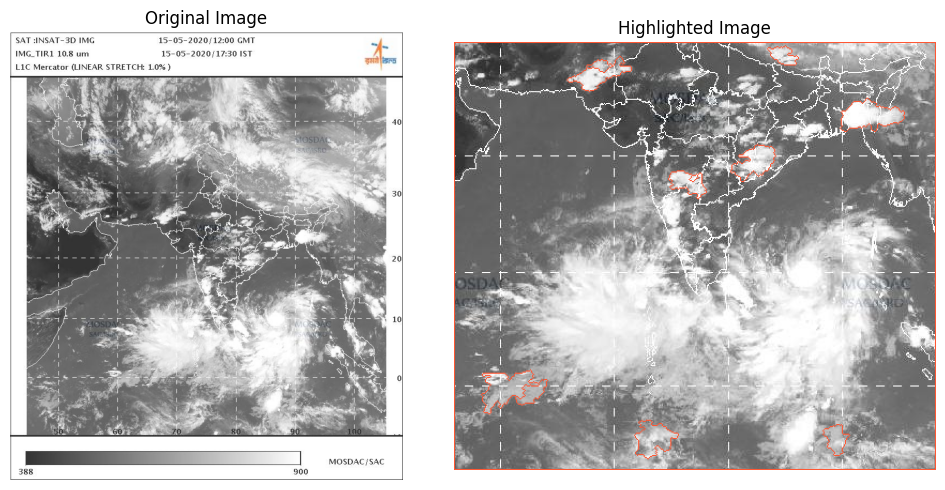

Processed image saved at: Dataset/processed_images/3DIMG_15MAY2020_1200_L1C_ASIA_MER_IR1_V01R00.jpg


In [16]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from skimage.segmentation import clear_border
from skimage import color

image_folder_path = 'Dataset/images/'

row = data.iloc[2]

filename = row['IR1']
image_path = image_folder_path + filename
image = Image.open(image_path)
cropped_image = image_crop(image, filename)
highlighted_image = image_highlighting(cropped_image)
save_processed_image(highlighted_image, filename)

## Generating Pre-processed images

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_folder_path = 'Dataset/images/'

image_counter = 0
image_not_counter = 0

for index, row in data.iterrows():
    filename = row['IR1']
    
    image_path = image_folder_path + filename
    
    try:
        image = Image.open(image_path)
        cropped_image = image_crop(image, filename)
        highlighted_image = image_highlighting(cropped_image)
        save_processed_image(highlighted_image, filename)
        image_counter += 1
    except Exception as err:
        print(err)
        image_not_counter += 1
    
print(image_counter)
print(image_not_counter)

## Loading the pre-processed images into dataframes

In [17]:
import tensorflow as tf
import pandas as pd
import os

def load_and_preprocess_image(image_path):
    try:
        image = tf.io.read_file('Dataset/processed_images/' + image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (256, 256))
        image = image / 255.0
        return image, image_path
    except Exception as err:
        print(err)
        return None, image_path

data['image'], data['IR1'] = zip(*data['IR1'].apply(load_and_preprocess_image))

data = data.dropna(subset=['image'])

images = tf.stack(list(data['image'].values))
labels = data['WMO_WIND'].values.astype(float)

filenames = data['IR1'].values

dataset_display = tf.data.Dataset.from_tensor_slices((images, labels, filenames))
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_15MAY2020_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_16MAY2020_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_19MAY2020_1200_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed t

{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_17MAY2021_0900_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_17MAY2021_1200_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_17MAY2021_1500_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed t

{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_22SEP2021_0600_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_22SEP2021_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_23SEP2021_1500_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed t

{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_04MAR2022_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_05MAR2022_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: Dataset/processed_images/3DIMG_07MAY2022_1800_L1C_ASIA_MER_IR1_V01R00.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]
{{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed t

## Displaying the dataset

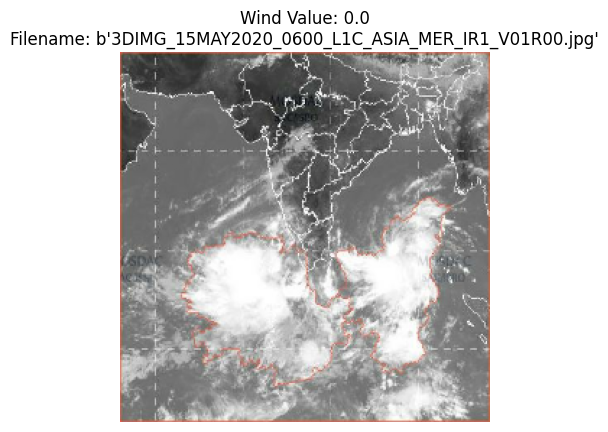

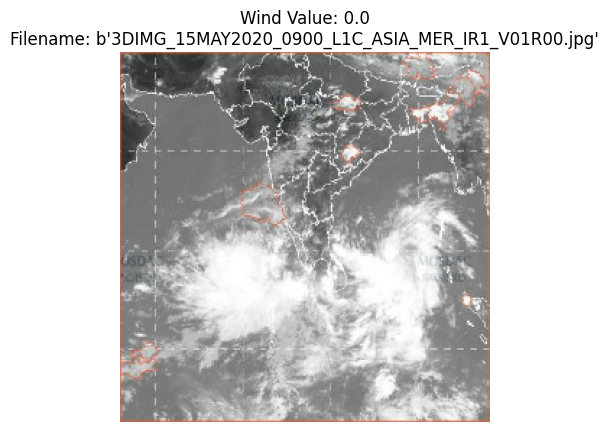

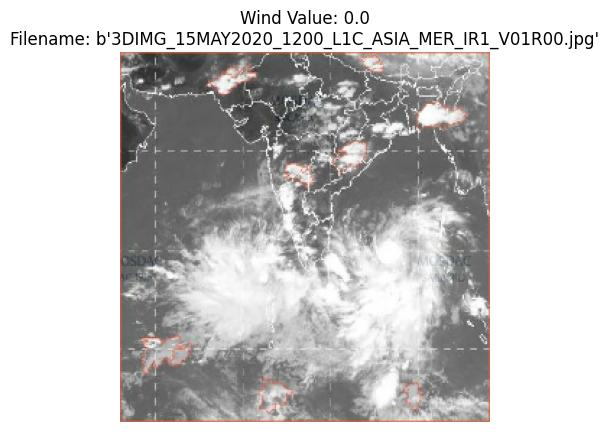

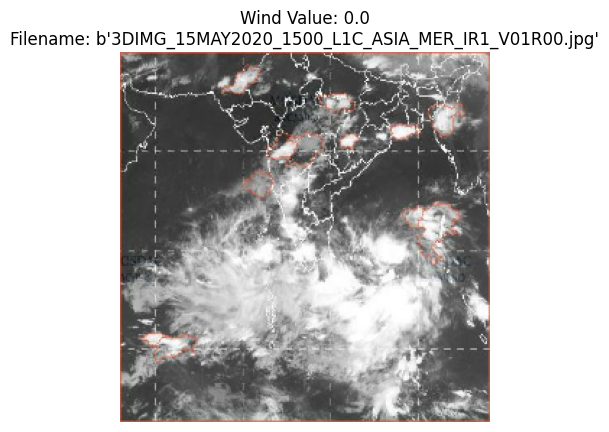

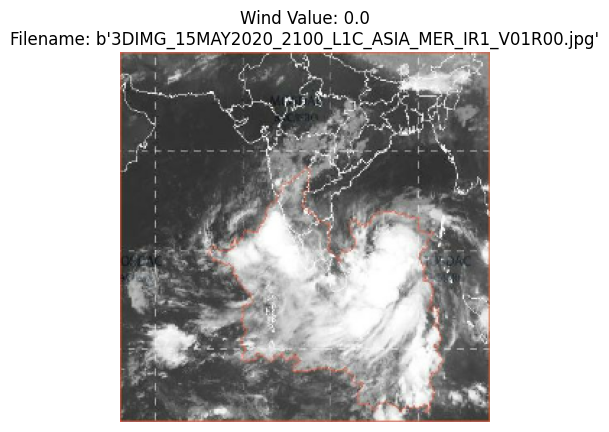

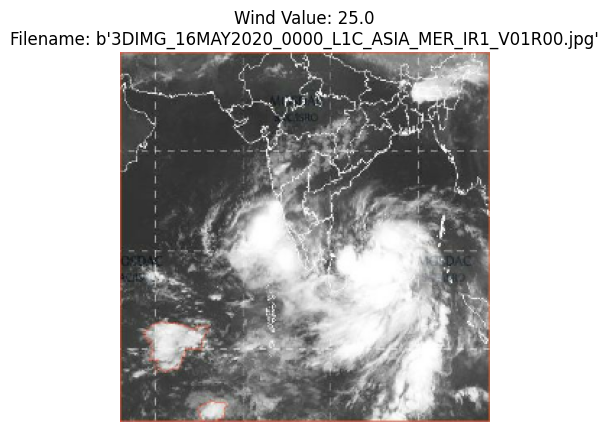

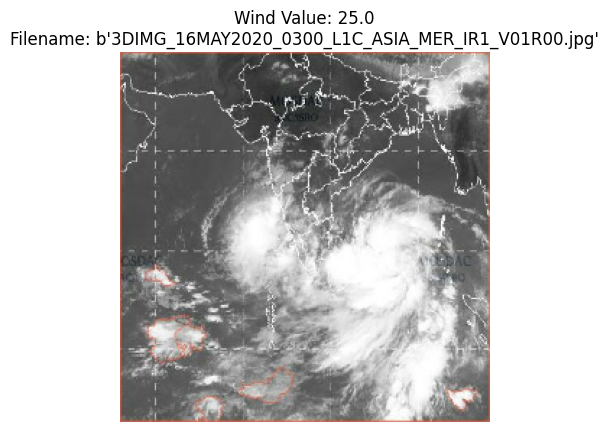

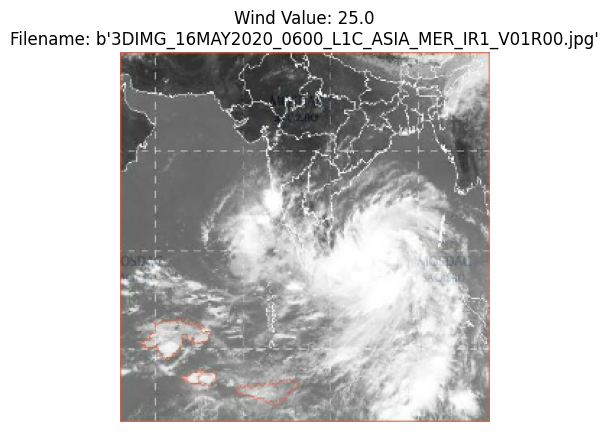

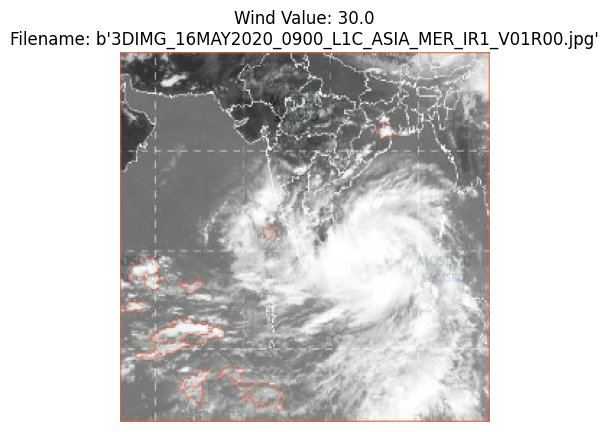

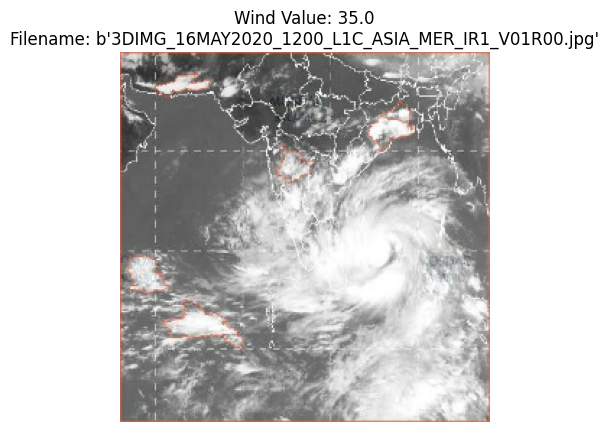

In [18]:
import matplotlib.pyplot as plt

num_images = 10
image_samples = dataset_display.take(num_images)

for image, label, image_filename in image_samples:
    wind_value = label.numpy() 
    plt.imshow(image)
    plt.title(f"Wind Value: {wind_value}\nFilename: {image_filename}")
    plt.axis('off')
    plt.show()

## Splitting the data

In [19]:
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

batch_size = 32
train_dataset = train_dataset.shuffle(train_size).batch(batch_size).prefetch(1)
val_dataset = val_dataset.batch(batch_size).prefetch(1)

## Data Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
)

# Simple CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

In [ ]:
hist = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# VGGNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
#model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
model.add(Dense(1))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['root_mean_squared_error'], color='teal', label='root_mean_squared_error')
plt.plot(hist.history['val_root_mean_squared_error'], color='orange', label='val_root_mean_squared_error')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# LeNet

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_351 (Conv2D)         (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_349 (MaxPooli  (None, 126, 126, 32)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_64 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_352 (Conv2D)         (None, 122, 122, 64)      51264     
                                                                 
 max_pooling2d_350 (MaxPooli  (None, 61, 61, 64)       0         
 ng2D)                                                           
                                                    

In [48]:
hist = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
15/15 [==============================] - 62s 4s/step - loss: 21.6598 - root_mean_squared_error: 33.9042 - val_loss: 21.6368 - val_root_mean_squared_error: 28.2461
Epoch 2/10
15/15 [==============================] - 57s 4s/step - loss: 21.0197 - root_mean_squared_error: 33.3820 - val_loss: 21.3342 - val_root_mean_squared_error: 29.0582
Epoch 3/10
15/15 [==============================] - 55s 4s/step - loss: 20.8062 - root_mean_squared_error: 33.0612 - val_loss: 20.9754 - val_root_mean_squared_error: 31.4408
Epoch 4/10
15/15 [==============================] - 46s 3s/step - loss: 20.5428 - root_mean_squared_error: 32.5398 - val_loss: 20.8746 - val_root_mean_squared_error: 32.1037
Epoch 5/10
15/15 [==============================] - 51s 3s/step - loss: 20.2994 - root_mean_squared_error: 32.0612 - val_loss: 22.3793 - val_root_mean_squared_error: 34.3961
Epoch 6/10
15/15 [==============================] - 54s 4s/step - loss: 19.9312 - root_mean_squared_error: 31.5427 - val_loss: 20.

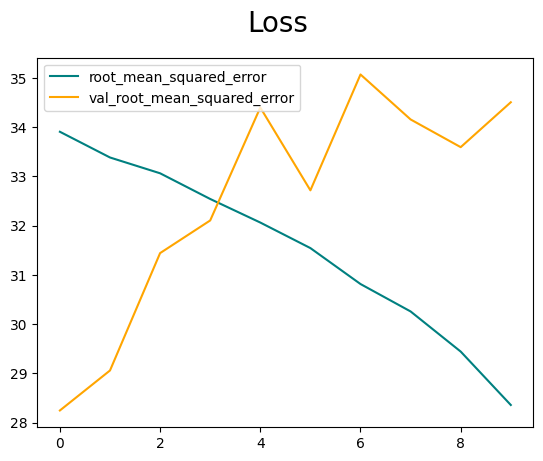

In [49]:
fig = plt.figure()
plt.plot(hist.history['root_mean_squared_error'], color='teal', label='root_mean_squared_error')
plt.plot(hist.history['val_root_mean_squared_error'], color='orange', label='val_root_mean_squared_error')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

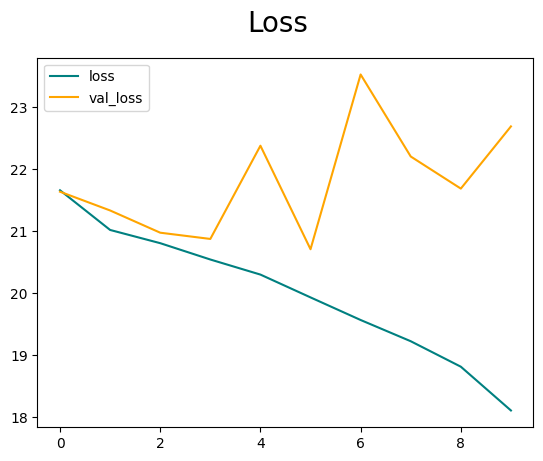

In [50]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# K-Fold Cross Validation LeNet

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))

    model.summary()
    
    model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                        

                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 64)       256       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 238144)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               60965120  
                                                                 
 batch_normalization_14 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_15 (Bat  (None, 128)              512       
 chNormalization)                                                
          

# K-Fold Cross Validation VGGNet

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold = 1

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()

    model.add(base_model)

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
    #model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))
    model.add(Dense(1))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    val_predictions = model.predict_classes(val_dataset)

    accuracy = accuracy_score(labels[val_index], val_predictions)
    precision = precision_score(labels[val_index], val_predictions, average='weighted')
    recall = recall_score(labels[val_index], val_predictions, average='weighted')
    f1 = f1_score(labels[val_index], val_predictions, average='weighted')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("----------------------")

    fold += 1

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

avg_accuracy = sum(accuracy_scores) / k
avg_precision = sum(precision_scores) / k
avg_recall = sum(recall_scores) / k
avg_f1 = sum(f1_scores) / k

print("Average evaluation metrics across all folds:")
print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1 Score: {avg_f1:.4f}")

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               8388864   
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 batch_normalization_20 (Bat  (None, 1)               

# K-Fold Cross Validation Simple CNN

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 30, 30, 16)     

Trainable params: 7,547,377
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_109 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 60, 60, 16)        4624      
 

# K-Fold Cross Validation ResNet

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold = 1

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    # Load the pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential()

    # Add the pre-trained ResNet50 layers
    model.add(base_model)

    # Add custom layers on top of the pre-trained layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_16 (Flatten)        (None, 131072)            0         
                                                                 
 dense_44 (Dense)            (None, 256)               33554688  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 64)              

# K-Fold Cross Validation AlexNet

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold = 1

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(pool_size=(3, 3),strides=2),
        Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3),strides=2),
        Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3),strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.4),
        Dense(4096, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='relu'),
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_359 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_354 (MaxPooli  (None, 30, 30, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_360 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_355 (MaxPooli  (None, 14, 14, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_361 (Conv2D)         (None, 14, 14, 384)       885120    
                                                                 
 conv2d_362 (Conv2D)         (None, 14, 14, 384)    

                                                                 
 conv2d_376 (Conv2D)         (None, 14, 14, 384)       885120    
                                                                 
 conv2d_377 (Conv2D)         (None, 14, 14, 384)       1327488   
                                                                 
 conv2d_378 (Conv2D)         (None, 14, 14, 256)       884992    
                                                                 
 max_pooling2d_365 (MaxPooli  (None, 6, 6, 256)        0         
 ng2D)                                                           
                                                                 
 flatten_121 (Flatten)       (None, 9216)              0         
                                                                 
 dense_541 (Dense)           (None, 4096)              37752832  
                                                                 
 dropout_78 (Dropout)        (None, 4096)              0         
          

# K-Fold Cross Validation CycloneNet

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold = 1

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
    )
    
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='relu')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_384 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_369 (MaxPooli  (None, 127, 127, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_385 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_370 (MaxPooli  (None, 62, 62, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_386 (Conv2D)         (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_371 (MaxPooli  (None, 30, 30, 128)   

                                                                 
 max_pooling2d_383 (MaxPooli  (None, 30, 30, 128)      0         
 ng2D)                                                           
                                                                 
 flatten_127 (Flatten)       (None, 115200)            0         
                                                                 
 dense_555 (Dense)           (None, 128)               14745728  
                                                                 
 dense_556 (Dense)           (None, 1)                 129       
                                                                 
Total params: 14,839,105
Trainable params: 14,839,105
Non-trainable params: 0
_________________________________________________________________
Average training loss: 21.18688201904297
Average training accuracy: 34.30696334838867
Training losses: [21.30526351928711, 21.25263214111328, 21.12631607055664, 21.094736099243164, 21.155462265014

## Overnight

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 14400)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               3686656   
          

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 14400)             0         
                                                                 
 dense_27 (Dense)            (None, 256)               3686656   
          

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 30, 30, 16)     

Trainable params: 3,893,745
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 60, 60, 16)        4624      
 

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold = 1

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    val_predictions = model.predict_classes(val_dataset)

    accuracy = accuracy_score(labels[val_index], val_predictions)
    precision = precision_score(labels[val_index], val_predictions, average='weighted')
    recall = recall_score(labels[val_index], val_predictions, average='weighted')
    f1 = f1_score(labels[val_index], val_predictions, average='weighted')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("----------------------")

    fold += 1

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

avg_accuracy = sum(accuracy_scores) / k
avg_precision = sum(precision_scores) / k
avg_recall = sum(recall_scores) / k
avg_f1 = sum(f1_scores) / k

print("Average evaluation metrics across all folds:")
print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1 Score: {avg_f1:.4f}")

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 16)     

                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 14400)             0         
                                                                 
 dense_38 (Dense)            (None, 256)               3686656   
                                                                 
 dense_39 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,696,625
Trainable params: 3,696,625
Non-trainable params: 0
_________________________________________________________________
Average training loss: 7.270814037322998
Average training accuracy: 11.388338470458985
Training losses: [6.5724921226501465, 6.824460029602051, 11.837871551513672, 5.487459182739258, 5.6317873001098

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_19 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_20 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                     

 conv2d_75 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_28 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_29 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
          

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_34 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_35 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                     

 conv2d_90 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_43 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_44 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
          

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 30, 30, 16)     

Trainable params: 4,354,289
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_122 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_125 (Conv2D)         (None, 60, 60, 16)        4624      
 

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_128 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 30, 30, 16)     

Trainable params: 15,412,721
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_140 (Conv2D)         (None, 60, 60, 16)        4624      


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_143 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 30, 30, 16)     

 dense_188 (Dense)           (None, 256)               131328    
                                                                 
 dense_189 (Dense)           (None, 128)               32896     
                                                                 
 dense_190 (Dense)           (None, 1)                 129       
                                                                 
Total params: 15,445,489
Trainable params: 15,445,489
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_153 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_151 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                         

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_157 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_158 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_156 (MaxPooli  (None, 30, 30, 16)     

 flatten_54 (Flatten)        (None, 14400)             0         
                                                                 
 dense_214 (Dense)           (None, 1024)              14746624  
                                                                 
 dense_215 (Dense)           (None, 512)               524800    
                                                                 
 dense_216 (Dense)           (None, 256)               131328    
                                                                 
 dense_217 (Dense)           (None, 128)               32896     
                                                                 
 dense_218 (Dense)           (None, 64)                8256      
                                                                 
 dense_219 (Dense)           (None, 1)                 65        
                                                                 
Total params: 15,453,681
Trainable params: 15,453,681
Non-trainable params: 

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_171 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_169 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_172 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_170 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_173 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_171 (MaxPooli  (None, 30, 30, 16)     

 flatten_59 (Flatten)        (None, 14400)             0         
                                                                 
 dense_244 (Dense)           (None, 1024)              14746624  
                                                                 
 dense_245 (Dense)           (None, 512)               524800    
                                                                 
 dense_246 (Dense)           (None, 256)               131328    
                                                                 
 dense_247 (Dense)           (None, 128)               32896     
                                                                 
 dense_248 (Dense)           (None, 64)                8256      
                                                                 
 dense_249 (Dense)           (None, 1)                 65        
                                                                 
Total params: 15,453,681
Trainable params: 15,453,681
Non-trainable params: 

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_186 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_184 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_187 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_185 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_188 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 30, 30, 16)     

                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_272 (Dense)           (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_273 (Dense)           (None, 1)                 65        
                                                                 
Total params: 15,453,681
Trainable params: 15,453,681
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195 (Conv2D)         (None, 254, 254, 16)      448       
                                         

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_49 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_199 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_50 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                     

 dense_301 (Dense)           (None, 128)               32896     
                                                                 
 dense_302 (Dense)           (None, 64)                8256      
                                                                 
 dense_303 (Dense)           (None, 1)                 65        
                                                                 
Total params: 15,453,937
Trainable params: 15,453,809
Non-trainable params: 128
_________________________________________________________________
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_58 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                       

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_231 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_229 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_232 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_230 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_233 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_231 (MaxPooli  (None, 30, 30, 16)     

 flatten_79 (Flatten)        (None, 14400)             0         
                                                                 
 dense_364 (Dense)           (None, 64)                921664    
                                                                 
 dense_365 (Dense)           (None, 128)               8320      
                                                                 
 dense_366 (Dense)           (None, 256)               33024     
                                                                 
 dense_367 (Dense)           (None, 512)               131584    
                                                                 
 dense_368 (Dense)           (None, 1024)              525312    
                                                                 
 dense_369 (Dense)           (None, 1)                 1025      
                                                                 
Total params: 1,630,641
Trainable params: 1,630,641
Non-trainable params: 0


In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_246 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_244 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_247 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_245 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_248 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_246 (MaxPooli  (None, 30, 30, 16)     

 dense_393 (Dense)           (None, 256)               33024     
                                                                 
 dense_394 (Dense)           (None, 512)               131584    
                                                                 
 dense_395 (Dense)           (None, 1)                 513       
                                                                 
Total params: 1,104,817
Trainable params: 1,104,817
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_258 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_256 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                           

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_261 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_259 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_262 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_260 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_263 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_261 (MaxPooli  (None, 30, 30, 16)     

Non-trainable params: 0
_________________________________________________________________
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_273 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_271 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_274 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_272 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_275 (Conv2D)         (None, 60, 60, 16)        4624      
                             

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_276 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_274 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_277 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_275 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_278 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_276 (MaxPooli  (None, 30, 30, 16)     

 dense_438 (Dense)           (None, 128)               32896     
                                                                 
 dense_439 (Dense)           (None, 64)                8256      
                                                                 
 dense_440 (Dense)           (None, 1)                 65        
                                                                 
Total params: 7,555,569
Trainable params: 7,555,569
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_288 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_286 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                           

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_291 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_289 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_292 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_290 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_293 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_291 (MaxPooli  (None, 30, 30, 16)     

Trainable params: 3,737,585
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_303 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_301 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_304 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_302 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_305 (Conv2D)         (None, 60, 60, 16)        4624      


In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_306 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_304 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_307 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_305 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_308 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_306 (MaxPooli  (None, 30, 30, 16)    

                                                                 
 conv2d_317 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_315 (MaxPooli  (None, 30, 30, 16)       0         
 ng2D)                                                           
                                                                 
 flatten_104 (Flatten)       (None, 14400)             0         
                                                                 
 dense_478 (Dense)           (None, 512)               7373312   
                                                                 
 dropout_49 (Dropout)        (None, 512)               0         
                                                                 
 dense_479 (Dense)           (None, 256)               131328    
                                                                 
 dropout_50 (Dropout)        (None, 256)               0         
          

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_321 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_319 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_322 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_320 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_323 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_321 (MaxPooli  (None, 30, 30, 16)    

                                                                 
 conv2d_332 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_330 (MaxPooli  (None, 30, 30, 16)       0         
 ng2D)                                                           
                                                                 
 flatten_109 (Flatten)       (None, 14400)             0         
                                                                 
 dense_498 (Dense)           (None, 256)               3686656   
                                                                 
 dropout_64 (Dropout)        (None, 256)               0         
                                                                 
 dense_499 (Dense)           (None, 128)               32896     
                                                                 
 dropout_65 (Dropout)        (None, 128)               0         
          

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

images = np.array(images)
labels = np.array(labels)

for train_index, val_index in skf.split(images, labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((images[train_index], labels[train_index]))
    val_dataset = tf.data.Dataset.from_tensor_slices((images[val_index], labels[val_index]))
    
    train_dataset = train_dataset.shuffle(1000).batch(32)
    val_dataset = val_dataset.batch(32)
    
    data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range (-20, 20) degrees
    width_shift_range=0.1,  # Randomly shift the width of images by 0-10% of the total width
    height_shift_range=0.1,  # Randomly shift the height of images by 0-10% of the total height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.1  # Randomly zoom images by 0-10%
    )
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    model.fit(train_dataset, epochs=20, verbose=0)
    
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print('Average training loss:', np.mean(train_losses))
print('Average training accuracy:', np.mean(train_accuracies))
print('Training losses:', train_losses)
print('Training accuracies:', train_accuracies)
print('Average validation loss:', np.mean(val_losses))
print('Average validation accuracy:', np.mean(val_accuracies))
print('Validation losses:', val_losses)
print('Validation accuracies:', val_accuracies)

C:\Users\Harsha\Desktop\Research Paper - Lavanya K\myenv\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_336 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_334 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_337 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_335 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_338 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_336 (MaxPooli  (None, 30, 30, 16)    

Trainable params: 1,863,409
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_348 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_346 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_349 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_347 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_350 (Conv2D)         (None, 60, 60, 16)        4624      
